In [57]:
import os 
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np

In [52]:
def get_train_dev_test_feats(path):
    """Helper function to get the train, dev, and test features for a given path"""
    def get_feats(full_path):
        return [line.strip().split("\t")[-1] for line in open(full_path).readlines()]
    return get_feats(f"{path}.trn"), get_feats(f"{path}.dev"), get_feats(f"{path}.tst")

def feature_overlap(path):
    """Calculate the percent of featuresets that were seen during training"""
    train_feats, dev_feats, test_feats = get_train_dev_test_feats(path)
    assert(len(train_feats) != 0 and len(dev_feats) != 0 and len(test_feats) != 0)
    
    seen_feats = set(train_feats + dev_feats)
    proportion_seen = len([f for f in test_feats if f in seen_feats])/len(test_feats)
    size = len(train_feats)
    return size, proportion_seen

In [110]:
def plot_stats(x, y, xlab, ylab):
    """Helper function to make the plots aesthetic and run stats"""
    x = np.asarray(x)
    y = np.asarray(y)
    a, b = np.polyfit(x, y, 1)
    plt.scatter(x, y, color="indigo", alpha=0.2, s=70)
    plt.plot(x, a*x+b, linestyle="-", color="indigo", linewidth=1)
    plt.xlabel(xlab)
    plt.ylabel(ylab)
    plt.title(f"{ylab} vs. {xlab}")
    plt.show()
    
    pearson = stats.pearsonr(proportions, sizes)
    spearman = stats.spearmanr(proportions, sizes)
    kendall_tau = stats.kendalltau(proportions, sizes)
    
    for name, stat in [("Pearson's R", pearson), ("Spearman", spearman), ("Kendall's Tau", kendall_tau)]:
        print(f"{name}:\t{stat.statistic :.3f},\t p = {stat.pvalue :.3f}")
    

In [84]:
def name(PATH_TO_DATA, funct):
    xs = []
    ys = []
    langs = []
    for language_family in [l for l in os.listdir(PATH_TO_DATA) if "." not in l]:
        for language in set([f.split(".")[0] for f in os.listdir(f"{PATH_TO_DATA}/{language_family}")]):
            x, y = funct(f"{PATH_TO_DATA}/{language_family}/{language}")
            xs.append(x)
            ys.append(y)
            langs.append(f"{language_family}/{language}")
    return xs, ys, langs
    

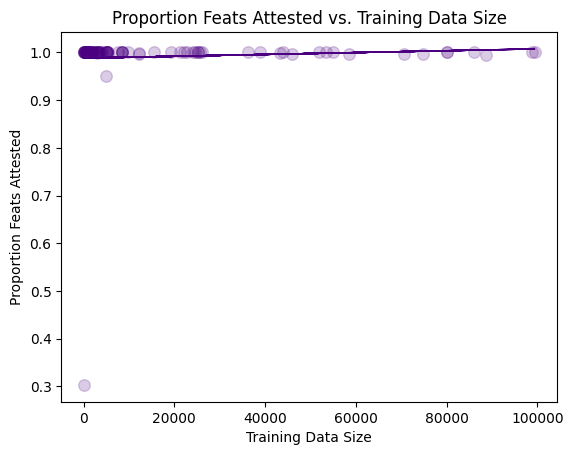

Pearson's R:	0.068,	 p = 0.522
Spearman:	-0.257,	 p = 0.014
Kendall's Tau:	-0.209,	 p = 0.014


In [111]:
PATH_TO_DATA = "LemmaSplitting/LemmaSplitData"
sizes, proportions, languages = name(PATH_TO_DATA, feature_overlap)

# proportions = []
# sizes = []

# for language_family in [l for l in os.listdir(PATH_TO_DATA) if "." not in l]:
#     for language in set([f.split(".")[0] for f in os.listdir(f"{PATH_TO_DATA}/{language_family}")]):
#         seen, size = feature_overlap(f"{PATH_TO_DATA}/{language_family}/{language}")
#         proportions.append(seen)
#         sizes.append(size)

plot_stats(sizes, proportions, "Training Data Size", "Proportion Feats Attested")